#   Probabilistic Numerical xCFC formulation
### (linearized and assuming spherical symmetry)
---

Domain $[0, R]$, choose basis functions that already satisfy the boundary conditions.
\begin{align}
    \phi_{n}(r) \ \equiv \ \sqrt{2} \, \sin(n \pi r / R) \, / \, r
\end{align}

\begin{align}
    \left( \partial_{r}^{2} \, + \, \frac{2}{r} \, \partial_{r} \, - \, k^{2}(r) \right) \phi_{n}(r)
    \ &= \
    \frac{1}{r} \left( \partial_{r}^{2} \, - \, k^{2}(r) \right) r \phi_{n}(r) \\
    \ &= \
    \left( \left(\frac{n \pi}{R}\right)^{2} \, - \, k^{2}(r) \right) \phi_{n}(r) \\
\end{align}

$$
j_{1}(r) \ \equiv \ \frac{\sin(r)}{r^2} - \frac{\cos (r)}{r}
$$

Domain $[0, R]$, choose basis functions that already satisfy the boundary conditions.
\begin{align}
    \phi_{n}(r) \ \equiv \ r \, j_{1}\left(\sqrt{\lambda_{n}} \, r\right)
\end{align}

where 

In [1]:
import numpy             as np
import sympy             as sp
import matplotlib.pyplot as plt

from scipy.optimize      import brentq
from scipy.integrate     import quad
from scipy.interpolate   import interp1d

N = 50
R = 1.0

rs = np.linspace(0.0, R, N)
# rs = np.logspace(-3, 1, N)

# Define first-order spherical Bessel function of the first kind
j1 = lambda r: np.sin(r) / r**2 - np.cos(r) / r


def find_j1_root(n):
    """
    Find the nth root of j1. 
    """
    # Start with an approximate guess based on root spacing
    approx   = (n + 0.5) * np.pi          # Good estimate for large n
    max_iter = 1000                       # Max attempts to bracket the root
    delta    = np.pi / (2.0 * max_iter)   # Step size to search around guess
    # Look for a sign change around the estimate
    for i in range(max_iter):
        a = np.float64(approx - delta * (i + 1))
        b = np.float64(approx + delta * (i + 1))
        if j1(a) * j1(b) < 0:
            root = brentq(j1, a, b, xtol=1.0e-17)
            return root
    raise ValueError(f"Could not bracket root #{n} after {max_iter} attempts.")


j1_roots = np.array([find_j1_root(n+1) for n in range(N)])

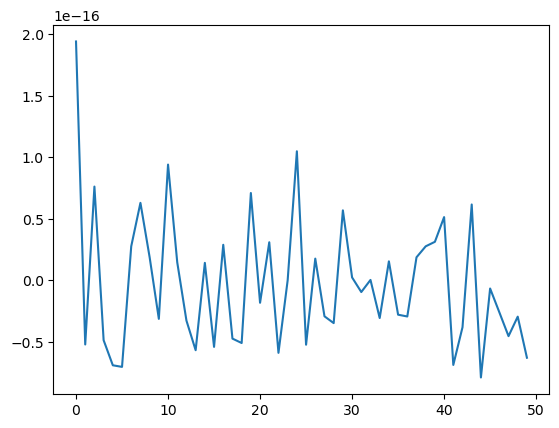

In [2]:
plt.plot(j1(j1_roots))

In [3]:
squared_norms_and_errors = np.array([quad(lambda r: (r * j1(j1_root * r))**2, 0.0, 1.0, limit=2500, epsabs=1.0e-16) for j1_root in j1_roots])

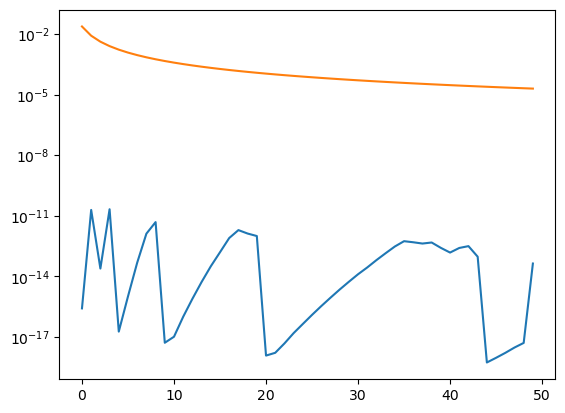

In [4]:
plt.plot(squared_norms_and_errors[:,1])
plt.plot(squared_norms_and_errors[:,0])
plt.yscale('log')

In [5]:
# Define vector basis functions
phi = lambda n, r: r * j1(j1_roots[n] * r) / np.sqrt(squared_norms_and_errors[n,0])

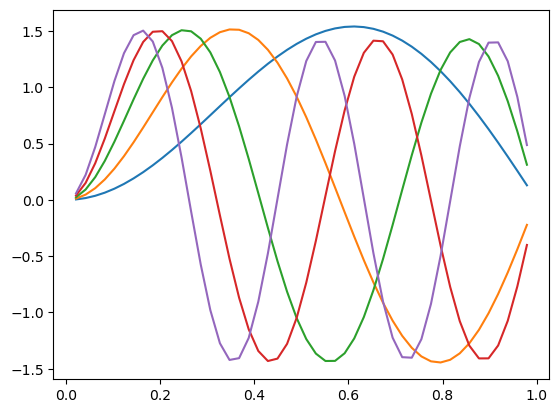

In [6]:
for n in range(5):
    plt.plot(rs[1:-1], phi(n,rs[1:-1]))   # Exclude 0 and 1 to avoid numerical issues

In [7]:
# # Check orthogonality in L2[0,1] of basis functions
# delta = np.zeros((N,N))
# error = np.zeros((N,N)) 
# for i, r_i in enumerate(j1_roots):
#     for j, r_j in enumerate(j1_roots):
#         if i != j:
#             integral = quad(lambda r: (r * j1(r_i * r)) * (r * j1(r_j * r)), 0.0, 1.0, limit=2500, epsabs=1.0e-16)
#             delta[i,j] = integral[0]
#             error[i,j] = integral[1]
# print(np.max(np.abs(delta)))
# print(np.max(np.abs(error)))

In [8]:
D = np.empty((N-2,N-2))
for i, r in enumerate(rs[1:-1]):
    for n in range(N-2):
        D[i,n] = phi(n, r)

In [9]:
D

array([[ 0.00405775,  0.0117857 ,  0.02332649, ...,  1.47186562,
         1.45234846,  1.42815018],
       [ 0.01619008,  0.04679195,  0.09192517, ..., -1.41687994,
        -1.43254129, -1.42594525],
       [ 0.03627459,  0.10397553,  0.20172663, ...,  1.32679635,
         1.39973254,  1.42227292],
       ...,
       [ 0.3846845 , -0.64509618,  0.87674459, ..., -0.65524572,
         0.40355075, -0.13697149],
       [ 0.25807109, -0.43882769,  0.6092011 , ...,  0.44641805,
        -0.27112732,  0.09138529],
       [ 0.12952322, -0.22207137,  0.31216267, ..., -0.22611329,
         0.13619235, -0.04571238]], shape=(48, 48))

In [10]:
np.linalg.det(D)

np.float64(3.669391761851862e+40)

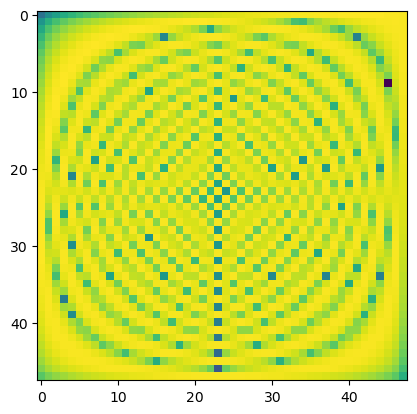

In [11]:
plt.imshow(np.log(np.abs(D)))

In [12]:
np.linalg.cond(D)

np.float64(1.0002466026429588)

In [13]:
D.T @ D

array([[ 4.90000000e+01,  6.52827912e-10, -9.24689746e-10, ...,
         4.94502890e-08, -5.40928177e-08,  5.92806200e-08],
       [ 6.52827912e-10,  4.90000000e+01,  1.59345068e-09, ...,
        -8.54443241e-08,  9.34829533e-08, -1.02467818e-07],
       [-9.24689746e-10,  1.59345068e-09,  4.90000000e+01, ...,
         1.21515877e-07, -1.32983980e-07,  1.45807223e-07],
       ...,
       [ 4.94502890e-08, -8.54443241e-08,  1.21515877e-07, ...,
         4.89996882e+01,  5.95440693e-04, -1.35017228e-03],
       [-5.40928177e-08,  9.34829533e-08, -1.32983980e-07, ...,
         5.95440693e-04,  4.89986504e+01,  4.10218543e-03],
       [ 5.92806200e-08, -1.02467818e-07,  1.45807223e-07, ...,
        -1.35017228e-03,  4.10218543e-03,  4.89766957e+01]],
      shape=(48, 48))

In [14]:
np.max(D.T @ D)

np.float64(48.99999999962114)

In [15]:
np.min(D.T @ D)

np.float64(-0.0013501722784912537)

In [16]:
np.min(np.abs(D.T @ D))

np.float64(6.528279117671139e-10)

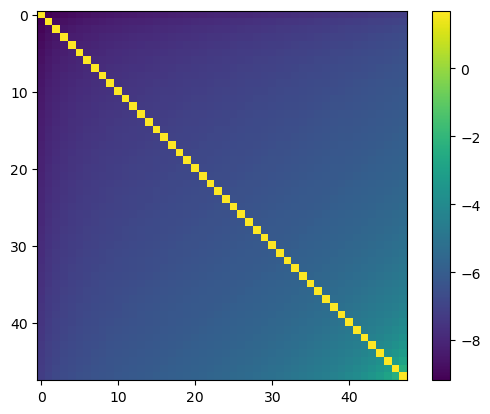

In [17]:
plt.imshow(np.log10(np.abs(D.T @ D)))
plt.colorbar()

In [18]:
np.linalg.cond(D @ D.T)

np.float64(1.000493266098783)

In [19]:
np.linalg.cond(D.T @ D)

np.float64(1.000493266098783)

/tmp/ipykernel_13531/2725045445.py:1: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(D @ D.T))


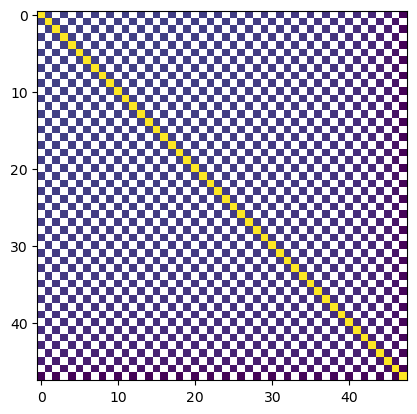

In [20]:
plt.imshow(np.log(D @ D.T))

In [21]:
# r, R, a = sp.symbols('r, R, a')

# sp.limit(r * (sp.sin(a * r) / (a * r)**2 - sp.cos(a * r) / (a * r)), r, 0)

In [22]:
# phi = sp.sqrt(2) * sp.sin(n * sp.pi * r / R) / r

# phi = sp.sin(n * sp.pi * r / R)**2 

# a =  sp.diff(sp.diff(phi, r), r).simplify()
# b = (sp.diff(2 * phi, r) / r).simplify()
# c = 2 * phi / r**2
# (a + b - c).simplify()

In [23]:
# r * (sp.sin(a * r) / (a * r)**2 - sp.cos(a * r) / (a * r))

## Scalar equations
---

Domain $[0, R]$, choose basis functions that already satisfy the boundary conditions.
\begin{align}
    \phi_{n}(r) \ \equiv \ \sqrt{2} \, \sin(n \pi r / R) \, / \, r
\end{align}


\begin{align}
    \mathscr{D}_{\text{scalar}} \
    \phi_{n}(r_{d})
    \ &= \
    \left( -\left(\frac{n \pi}{R}\right)^{2} \, - \, k^{2}(r_{d}) \right) \phi_{n}(r_{d})
\end{align}

In [24]:
# n, r, R = sp.symbols('n, r, R')

# phi_sca_sym = sp.sqrt(2) * sp.sin(n * sp.pi * r / R) / r
# phi_sca_sym

In [25]:
# sp.simplify( (sp.diff(phi_sca_sym, r, r) + 2/r * sp.diff(phi_sca_sym, r)) / phi_sca_sym )

In [26]:
phi_sca = lambda n, r: np.sin(n * np.pi * r / R) / r

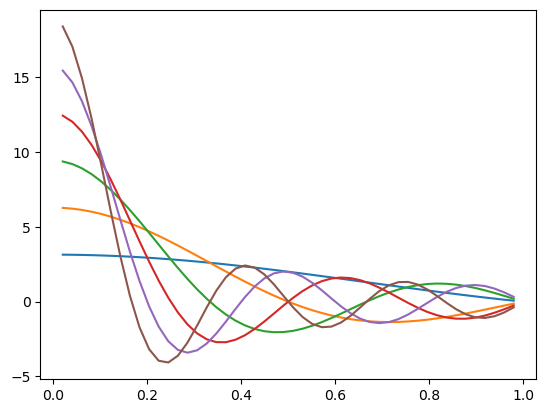

In [27]:
for n in range(1,7):
    plt.plot(rs[1:-1], phi_sca(n,rs[1:-1]))   # Exclude 0 and 1 to avoid numerical issues

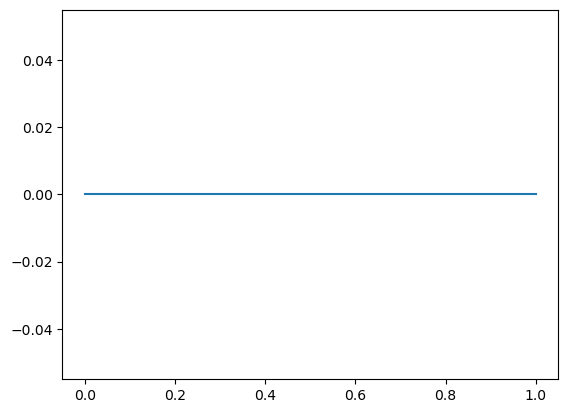

In [28]:
k2 = lambda r: 0*(np.sin(10*r)/(r+0.01) + np.cos(15*r) + r - r**2 )**2

plt.plot(rs, k2(rs))

In [29]:
DΦ = np.empty((N-2,N-2))
for i, r in enumerate(rs[1:-1]):
    for j, n in enumerate(range(1,N-1)):
        DΦ[i,j] = (-(n * np.pi / R)**2 - k2(r)) * phi_sca(n, r)

In [30]:
Φ = np.empty((N-2,N-2))
for i, r in enumerate(rs[1:-1]):
    for j, n in enumerate(range(1,N-1)):
        Φ[i,j] = phi_sca(n, r)

In [31]:
DΦ

array([[-3.09850385e+01, -2.47371012e+02, -8.32017079e+02, ...,
        -1.95616460e+05, -1.36610641e+05, -7.13895288e+04],
       [-3.09213764e+01, -2.45340099e+02, -8.16673983e+02, ...,
         1.92009127e+05,  1.35489070e+05,  7.12428513e+04],
       [-3.08154474e+01, -2.41977476e+02, -7.91479408e+02, ...,
        -1.86085603e+05, -1.33632061e+05, -7.09987907e+04],
       ...,
       [-2.00970309e+00,  1.57811398e+01, -5.16182223e+01, ...,
         1.21360176e+04, -8.71513443e+03,  4.63035592e+03],
       [-1.31580325e+00,  1.04400042e+01, -3.47520844e+01, ...,
        -8.17060117e+03,  5.76549233e+03, -3.03161069e+03],
       [-6.45521636e-01,  5.15356274e+00, -1.73336891e+01, ...,
         4.07534291e+03, -2.84605502e+03,  1.48728185e+03]],
      shape=(48, 48))

In [32]:
Φ

array([[ 3.13944078,  6.26598092,  9.36677281, ...,  9.36677281,
         6.26598092,  3.13944078],
       [ 3.13299046,  6.21453731,  9.19404162, ..., -9.19404162,
        -6.21453731, -3.13299046],
       [ 3.1222576 ,  6.12936108,  8.91040339, ...,  8.91040339,
         6.12936108,  3.1222576 ],
       ...,
       [ 0.2036255 , -0.39974094,  0.58111326, ..., -0.58111326,
         0.39974094, -0.2036255 ],
       [ 0.13331874, -0.2644484 ,  0.39123581, ...,  0.39123581,
        -0.2644484 ,  0.13331874],
       [ 0.06540502, -0.13054127,  0.1951411 , ..., -0.1951411 ,
         0.13054127, -0.06540502]], shape=(48, 48))

In [33]:
np.linalg.det(DΦ)

np.float64(1.9484731826562208e+223)

In [34]:
np.linalg.det(Φ)

np.float64(2.374045717556025e+53)

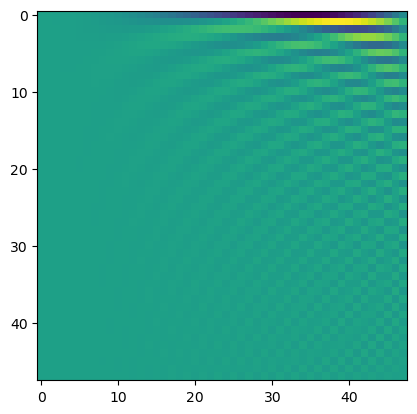

In [35]:
plt.imshow(DΦ)

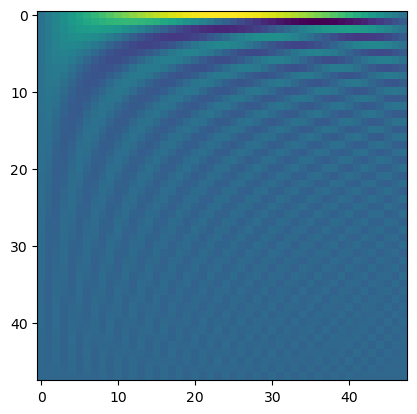

In [36]:
plt.imshow(Φ)

In [37]:
np.linalg.cond(DΦ)

np.float64(24977.287708253327)

In [38]:
np.linalg.cond(Φ)

np.float64(48.000000000000114)

In [39]:
DΦ.T @ DΦ

array([[2.07844382e+04, 9.12929441e+04, 1.98383340e+05, ...,
        3.05146243e+06, 2.12369966e+06, 1.10752506e+06],
       [9.12929441e+04, 6.85232505e+05, 1.60142683e+06, ...,
        2.44114890e+07, 1.69897427e+07, 8.86012496e+06],
       [1.98383340e+05, 1.60142683e+06, 5.18095004e+06, ...,
        8.23894895e+07, 5.73398880e+07, 2.99031781e+07],
       ...,
       [3.05146243e+06, 2.44114890e+07, 8.23894895e+07, ...,
        2.86388591e+11, 2.07929438e+11, 1.07463462e+11],
       [2.12369966e+06, 1.69897427e+07, 5.73398880e+07, ...,
        2.07929438e+11, 2.08982252e+11, 1.16159681e+11],
       [1.10752506e+06, 8.86012496e+06, 2.99031781e+07, ...,
        1.07463462e+11, 1.16159681e+11, 1.10332444e+11]], shape=(48, 48))

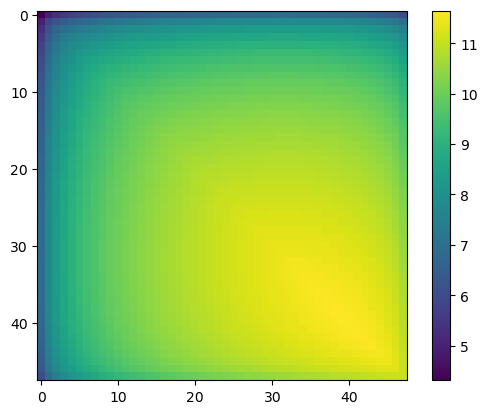

In [40]:
plt.imshow(np.log10(DΦ.T @ DΦ))
plt.colorbar()

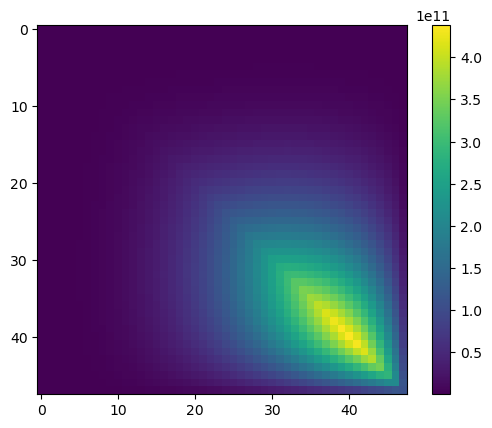

In [41]:
plt.imshow(DΦ.T @ DΦ)
plt.colorbar()

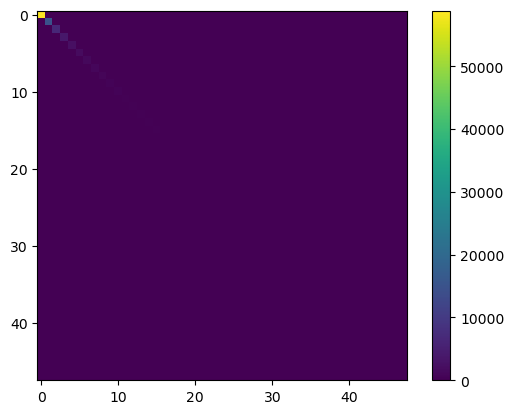

In [42]:
plt.imshow(Φ @ Φ.T)
plt.colorbar()

In [43]:
np.linalg.cond(DΦ @ DΦ.T)

np.float64(623864901.1992788)

In [44]:
np.linalg.cond(DΦ.T @ DΦ)

np.float64(623864901.7427764)

\begin{align*}
    E
    \ &= \
    \rho h W^{2} - p 
    \\
    S^{r} 
    \ &= \
    \rho h W^{2} v^{r} \\
    S \
    \ &= \
    \rho h W^{2} (v^{r})^{2} + 3 p
\end{align*}

\begin{align}
    \nabla^{2} \delta\boldsymbol{X} \, + \, \frac{1}{3} \, \boldsymbol{\nabla} \left( \boldsymbol{\nabla} \cdot \delta\boldsymbol{X} \right)
    \ &= \
    \delta\boldsymbol{S}_{\boldsymbol{X}} \\
    \left(\nabla^{2}
    + S_{1} / \psi^{2}
    + \, 7 S_{7} / \psi^{8}
    \right) \delta \psi
    \ &= \
    \delta S_{1} / \psi
    + \delta S_{7} / \psi^{7} \\
    \left(\nabla^{2} - S_{\alpha\psi} \right) \delta \left( \alpha \psi \right)
    \ &= \
    \left( \alpha \psi \right) \delta S_{\alpha\psi} \\
    \nabla^{2} \delta \boldsymbol{\beta} \, + \, \frac{1}{3} \, \boldsymbol{\nabla}\left( \boldsymbol{\nabla} \cdot \delta \boldsymbol{\beta} \right)
    \ &= \
    \delta \boldsymbol{S}_{\boldsymbol{\beta}}
\end{align}

\begin{align*}
k^{2}_{\psi}
\ &= \
- S_{1} / \psi^{2} \, - \, 7 S_{7} / \psi^{8} \\
k^{2}_{\alpha \psi}
\ &= \
S_{\alpha\psi}
\end{align*}

In [45]:
rs

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [46]:
N_d = N-2

v_r = np.zeros(N_d)
ε   = np.zeros(N_d)
ρ   = np.zeros(N_d)
p   = np.zeros(N_d)

M = 1.0e-5
C = M / 2.0

ψ  = 1.0 + C / rs[1:-1]
αψ = 1.0 - C / rs[1:-1]


W  = 1.0 / np.sqrt(1.0 - v_r**2)
ρh = ρ * (1.0 + ε) + p

E   = ρh * W**2 - p
S_r = ρh * W**2 * v_r
S   = ρh * W**2 * v_r**2 + 3.0 * p

δE = np.zeros(N_d)
δS = np.zeros(N_d)

\begin{align}
\boldsymbol{S}_{\boldsymbol{X}} \ &\equiv \ 8 \pi \, \boldsymbol{S} \\
S_{1} \ &\equiv \ -2\pi \, E \\
S_{7} \ &\equiv \ -\frac{1}{8} \, \mathsf{A}^{2} \\
S_{\alpha \psi} \ &\equiv \ 2 \pi \, \big( E + 2 S \big) / \psi^{2} \, + \, \frac{7}{8} \, \mathsf{A}^{2} / \psi^{8} \\
\boldsymbol{S}_{\boldsymbol{\beta}} \ &\equiv \ 16 \pi \, \boldsymbol{S} \, \alpha / \psi^{6} \, + \, 2 \, \mathsf{A} \boldsymbol{\nabla} \left(\alpha / \psi^{6} \right)
\end{align}
where we defined the auxiliary matrix function,
\begin{align}
\mathsf{A}
\ &\equiv \
\boldsymbol{\nabla} \boldsymbol{X}
\, + \,
\left(\boldsymbol{\nabla} \boldsymbol{X} \right)^{\text{T}}
\, - \,
\frac{2}{3} \left(\boldsymbol{\nabla} \cdot \boldsymbol{X}\right) \mathbb{1} , \\
\mathsf{A}^{2}
\ &\equiv \
\text{Tr}\left( \mathsf{A} \, \mathsf{A}^{\text{T}} \right) .
\end{align}

In [47]:
A2 = 0.0

# S_X_r =   8.0 * np.pi * S_r
S_1   = - 2.0 * np.pi * E
S_7   = - 1.0 / 8.0 * A2
S_αψ  =   2.0 * np.pi * (E + 2.0 * S) / ψ**2 + 7.0 / 8.0 * A2 / ψ**8

k2_ψ  = - S_1 / ψ**2 - 7.0 * S_7 / ψ**8
k2_αψ =   S_αψ

In [48]:
k2_ψ

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

\begin{align}
\delta \boldsymbol{S}_{\boldsymbol{X}} \ &= \ 8 \pi \, \delta \boldsymbol{S} \\
\delta S_{1} \ &= \ -2\pi \, \delta E \\
\delta S_{7} \ &= \ - \frac{1}{8} \, \delta \mathsf{A}^{2} \\
\delta S_{\alpha \psi} \ &= \ 2 \pi \big( (\delta E + 2 \delta S) \psi \, - \, 2 ( E + 2 S) \delta \psi \big) / \psi^{3} \notag \\
& \ \ \ \ \, + \, \frac{7}{8} \left(  \delta \mathsf{A}^{2} \psi \, - \, 8 \, \mathsf{A}^{2} \, \delta \psi \right) / \psi^{9} \\
\delta \boldsymbol{S}_{\boldsymbol{\beta}} \ &= \ 16 \pi \big( \boldsymbol{S} \, \delta(\alpha\psi) - 7 \boldsymbol{S} \alpha \, \delta \psi + \alpha \psi \, \delta \boldsymbol{S} \big) / \psi^{7} \notag \\
& \ \ \ \ \, + \, 2 \, \delta \mathsf{A} \boldsymbol{\nabla} \left(\alpha / \psi^{6} \right) \notag \\
& \ \ \ \ \, + \, 2 \, \mathsf{A} \boldsymbol{\nabla} \left( \left(\delta(\alpha \psi) - 7 \alpha \delta \psi \right) / \psi^{7} \right)
\end{align}
in which the linearized auxiliary matrix function reads,
\begin{align}
    \delta \mathsf{A}
    \ &= \
    \boldsymbol{\nabla} \delta \boldsymbol{X}
    \, + \,
    \left(\boldsymbol{\nabla} \delta \boldsymbol{X} \right)^{\text{T}}
    \, - \,
    \frac{2}{3} \, \left(\boldsymbol{\nabla} \cdot \delta \boldsymbol{X}\right) \mathbb{1} \\
    \delta \mathsf{A}^{2}
    \ &= \
    2 \, \text{Tr}\left( \mathsf{A} \, \delta \mathsf{A}^{\text{T}} \right) .
\end{align}

In [49]:
δA2 = 0.0

# δS_X_r =   8.0 * np.pi * δS_r
δS_1   = - 2.0 * np.pi * δE
δS_7   = - 1.0 / 8.0 * δA2
δS_αψ  =   2.0 * np.pi * ( (δE + 2.0 * δS) * ψ - 2.0 * (E + 2.0 * S) * δψ) / ψ**3 \
         + 7.0 / 8.0 * (δA2 * ψ - 8.0 * A2 * δψ) / ψ**9
# δS_β_r =  16.0 * np.pi * ( S_r * δαψ - 7.0 * S_r * α * δψ + αψ * δS_r  ) / ψ**7 \
#          + 2.0 * δA

NameError: name 'δψ' is not defined

Domain $[0, R]$, choose basis functions that already satisfy the boundary conditions.
\begin{align}
    \phi_{n}(r) \ \equiv \ \, \sin(n \pi r / R) \, / \, r
\end{align}

\begin{align}
    \left( \partial_{r}^{2} \, + \, \frac{2}{r} \, \partial_{r} \, - \, k^{2}(r) \right) \phi_{n}(r)
    \ &= \
    - \left( \frac{n^{2} \pi^{2}}{R^{2}} \, + \, k^{2}(r) \right) \phi_{n}(r) \\
\end{align}

In [50]:
# n, r, R = sp.symbols('n, r, R')

# phi_sca_sym = sp.sin(n * sp.pi * r / R) / r
# phi_sca_sym

In [51]:
# sp.simplify( (sp.diff(phi_sca_sym, r, r) + 2/r * sp.diff(phi_sca_sym, r)) / phi_sca_sym )

In [52]:
phi_sca   = lambda n, r: np.sin(n * np.pi * r / R) / r

def create_DΦ_scalar(k2):
    DΦ = np.empty((N-2,N-2))
    for i, r in enumerate(rs[1:-1]):
        for j, n in enumerate(range(1,N-1)):
            DΦ[i,j] = - ((n * np.pi / R)**2 + k2[i]) * phi_sca(n, r)

            # if j == N-3:
            #     DΦ[i,j] = 0.0
            # if j == N-4:
            #     DΦ[i,j] = 0.0

    return DΦ

def create_Φ_scalar():
    Φ = np.empty((N-2,N-2))
    for i, r in enumerate(rs[1:-1]):
        for j, n in enumerate(range(1,N-1)):
            Φ[i,j] = phi_sca(n, r)
            
            # if j == N-3:
            #     Φ[i,j] = 1.0
            # if j == N-4:
            #     Φ[i,j] = 1.0 / r

    return Φ

In [53]:
DΦ_ψ = create_DΦ_scalar(k2_ψ)
# Φ    = create_Φ_scalar()

In [54]:
ψ

array([1.000245  , 1.0001225 , 1.00008167, 1.00006125, 1.000049  ,
       1.00004083, 1.000035  , 1.00003062, 1.00002722, 1.0000245 ,
       1.00002227, 1.00002042, 1.00001885, 1.0000175 , 1.00001633,
       1.00001531, 1.00001441, 1.00001361, 1.00001289, 1.00001225,
       1.00001167, 1.00001114, 1.00001065, 1.00001021, 1.0000098 ,
       1.00000942, 1.00000907, 1.00000875, 1.00000845, 1.00000817,
       1.0000079 , 1.00000766, 1.00000742, 1.00000721, 1.000007  ,
       1.00000681, 1.00000662, 1.00000645, 1.00000628, 1.00000613,
       1.00000598, 1.00000583, 1.0000057 , 1.00000557, 1.00000544,
       1.00000533, 1.00000521, 1.0000051 ])

In [55]:
Φ

array([[ 3.13944078,  6.26598092,  9.36677281, ...,  9.36677281,
         6.26598092,  3.13944078],
       [ 3.13299046,  6.21453731,  9.19404162, ..., -9.19404162,
        -6.21453731, -3.13299046],
       [ 3.1222576 ,  6.12936108,  8.91040339, ...,  8.91040339,
         6.12936108,  3.1222576 ],
       ...,
       [ 0.2036255 , -0.39974094,  0.58111326, ..., -0.58111326,
         0.39974094, -0.2036255 ],
       [ 0.13331874, -0.2644484 ,  0.39123581, ...,  0.39123581,
        -0.2644484 ,  0.13331874],
       [ 0.06540502, -0.13054127,  0.1951411 , ..., -0.1951411 ,
         0.13054127, -0.06540502]], shape=(48, 48))

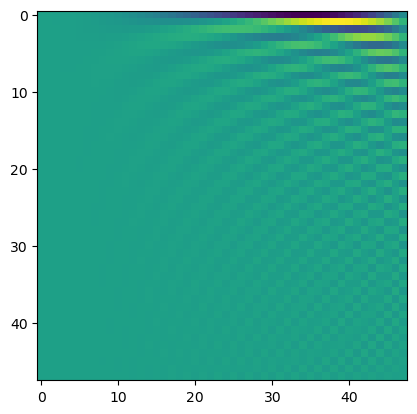

In [56]:
plt.imshow(DΦ)
# plt.imshow(Φ)

In [57]:
DΦ

array([[-3.09850385e+01, -2.47371012e+02, -8.32017079e+02, ...,
        -1.95616460e+05, -1.36610641e+05, -7.13895288e+04],
       [-3.09213764e+01, -2.45340099e+02, -8.16673983e+02, ...,
         1.92009127e+05,  1.35489070e+05,  7.12428513e+04],
       [-3.08154474e+01, -2.41977476e+02, -7.91479408e+02, ...,
        -1.86085603e+05, -1.33632061e+05, -7.09987907e+04],
       ...,
       [-2.00970309e+00,  1.57811398e+01, -5.16182223e+01, ...,
         1.21360176e+04, -8.71513443e+03,  4.63035592e+03],
       [-1.31580325e+00,  1.04400042e+01, -3.47520844e+01, ...,
        -8.17060117e+03,  5.76549233e+03, -3.03161069e+03],
       [-6.45521636e-01,  5.15356274e+00, -1.73336891e+01, ...,
         4.07534291e+03, -2.84605502e+03,  1.48728185e+03]],
      shape=(48, 48))

2304.000000000046


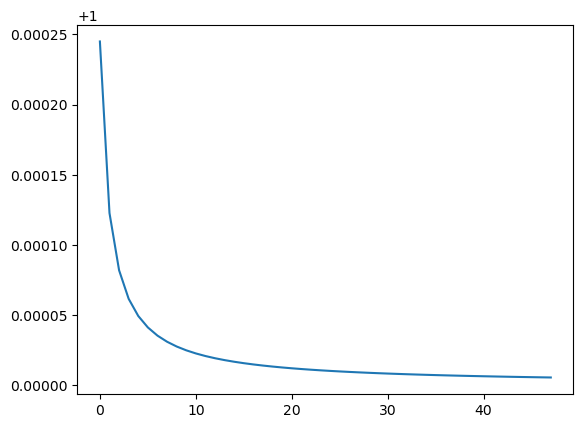

In [58]:
w_ψ = np.linalg.inv( Φ.T @  Φ) @  Φ.T @ ψ
w_ψ = np.linalg.inv(DΦ.T @ DΦ) @ DΦ.T @ S_1


print(np.linalg.cond(Φ.T @ Φ))

# plt.plot(w_ψ[:])
# plt.plot(Φ @ w_ψ)
# plt.plot((DΦ @ w_ψ)[:])
plt.plot(ψ)

In [59]:
w_ψ

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

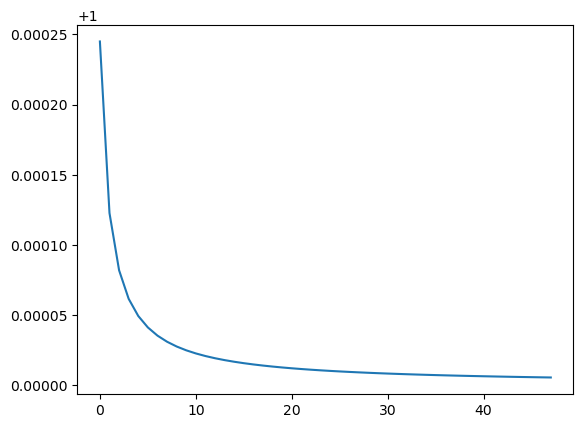

In [60]:
plt.plot(ψ)

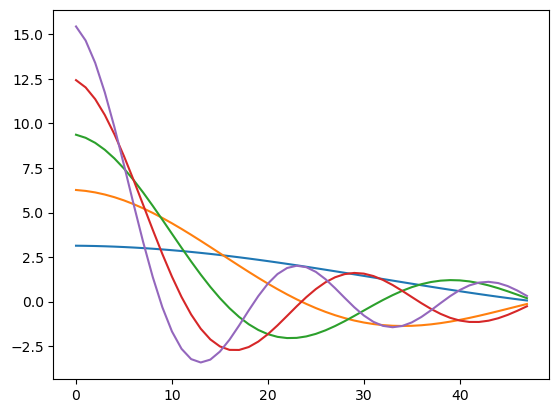

In [61]:
for i in range(5):
    plt.plot(Φ[:,i])

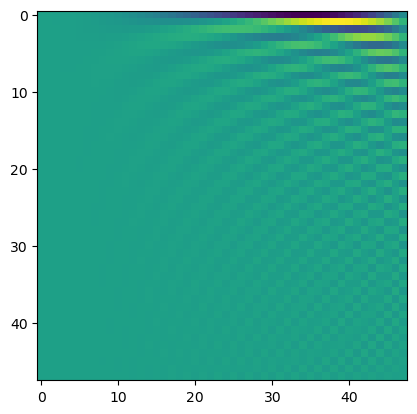

In [62]:
DΦ = create_DΦ_scalar(np.zeros_like(k2_ψ))

plt.imshow(DΦ)

In [63]:
k2

<function __main__.<lambda>(r)>

# Test
---

In [67]:
# Load TOV solution
(rs_0, m_0, p_0, ρ_0, Rs_0, α_0, ψ_0) = np.load('../../data/tov_112.npy')

In [68]:
len(rs_0)

42

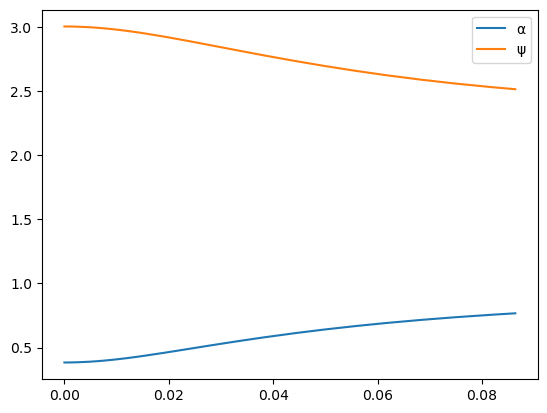

In [69]:
plt.plot(Rs_0, α_0, label='α')
plt.plot(Rs_0, ψ_0, label='ψ')
# plt.yscale('log')
plt.legend()

In [70]:
N_d      = 100
N_d_fine = 100
N        =  50

Rs      = np.linspace(Rs_0[10], Rs_0[-1], N_d)
Rs_fine = np.linspace(Rs_0[10], Rs_0[-1], N_d_fine) 

α = interp1d(Rs_0, α_0)(Rs)
ψ = interp1d(Rs_0, ψ_0)(Rs)

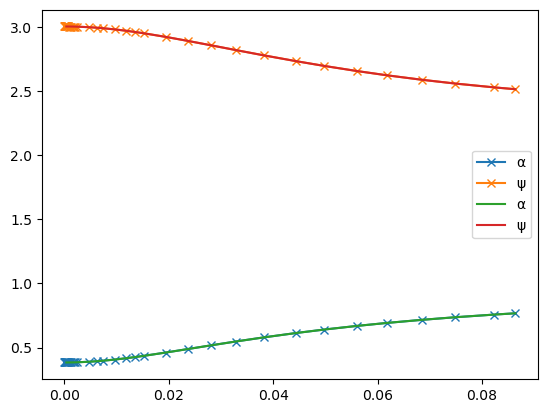

In [71]:
plt.plot(Rs_0, α_0, label='α', marker='x')
plt.plot(Rs_0, ψ_0, label='ψ', marker='x')
plt.plot(Rs,   α,   label='α')
plt.plot(Rs,   ψ,   label='ψ')
# plt.yscale('log')
plt.legend()

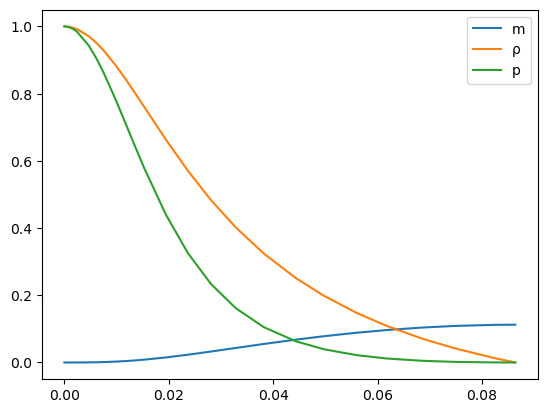

In [72]:
plt.plot(Rs_0, m_0, label='m')
plt.plot(Rs_0, ρ_0, label='ρ')
plt.plot(Rs_0, p_0, label='p')
# plt.yscale('log')
plt.legend()

In [73]:
p = interp1d(Rs_0, p_0)(Rs)
ρ = interp1d(Rs_0, ρ_0)(Rs)

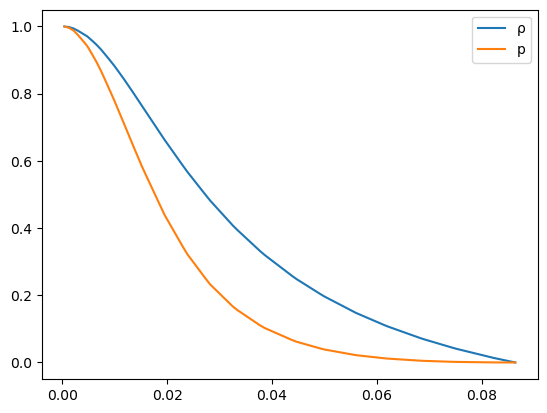

In [74]:
plt.plot(Rs, ρ, label='ρ')
plt.plot(Rs, p, label='p')
# plt.yscale('log')
plt.legend()

In [75]:
v_r = np.zeros_like(r)

R = Rs[-1]
M = m_0[-1]
C = M / 2.0

ρh = ρ + p
W  = 1.0 / np.sqrt(1.0 - v_r**2)

E   = ρh * W**2 - p
S_r = ρh * W**2 * v_r
S   = ρh * W**2 * v_r**2 + 3.0 * p

E_tilde   = E   * ψ**6
S_tilde_r = S_r * ψ**6
S_tilde   = S   * ψ**6

S_ψ  = -2.0 * np.pi * E_tilde / ψ
S_αψ =  2.0 * np.pi * (E_tilde + 2.0 * S_tilde) / ψ**2

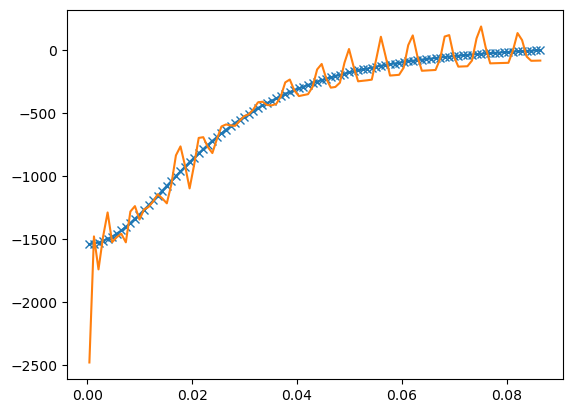

In [76]:
plt.plot(Rs, S_ψ, marker='x')
plt.plot(Rs, np.gradient(np.gradient(ψ, Rs), Rs) + 2.0 / Rs * np.gradient(ψ, Rs) )

In [77]:
φ  = lambda n, r: np.sin(n * np.pi * r / R) / r #* R**2 / (n+1)**2
φ2 = lambda n, r: 0 * np.cos(n * np.pi * r / R) / r #* R**2 / (n+1)**2

Dφ  = lambda n, r: -(n * np.pi / R)**2 * φ (n, r)
Dφ2 = lambda n, r: -(n * np.pi / R)**2 * φ2(n, r)

DΦ = np.empty((N_d+1,N))
for d, r in enumerate(Rs):
    for i in range(N//2):

        DΦ[d,2*i  ] = Dφ (i,r) 
        DΦ[d,2*i+1] = Dφ2(i,r) 

        if i == 0:
            DΦ[d,0] = 0.0
            DΦ[d,1] = 0.0

for i in range(N//2):
    DΦ[N_d,2*i  ] = φ (i,Rs[-1])
    DΦ[N_d,2*i+1] = φ2(i,Rs[-1])
        
    if i == 0:
        DΦ[N_d,0] = 1.0 
        DΦ[N_d,1] = 0 * 1.0 / Rs[-1]


Φ = np.empty((N_d,N))
for d, r in enumerate(Rs):
    for i in range(N//2):

        Φ[d,2*i  ] = φ (i,r) 
        Φ[d,2*i+1] = φ2(i,r) 

        if i == 0:
            Φ[d,0] = 1.0 
            Φ[d,1] = 0 #1.0 / r

Φ_fine = np.empty((N_d_fine,N))
for d, r in enumerate(Rs_fine):
    for i in range(N//2):

        Φ_fine[d,2*i  ] = φ (i,r) 
        Φ_fine[d,2*i+1] = φ2(i,r) 

        if i == 0:
            Φ_fine[d,0] = 1.0 
            Φ_fine[d,1] = 0 * 1.0 / r

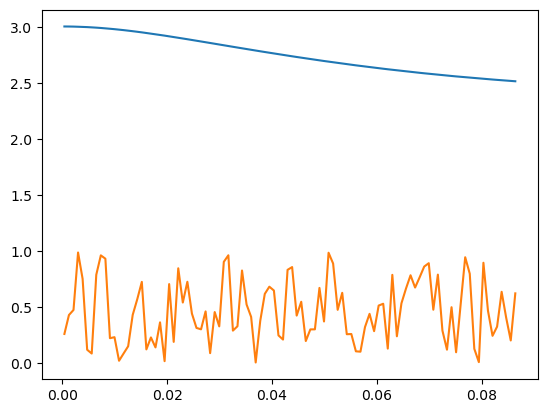

In [78]:
ψ_0 = np.random.rand(N_d) #  ψ * (1.0 + 0.2 * np.sin(9.0*np.pi*Rs/R) + 0.7 * np.cos(5.0*np.pi*Rs/R) )

plt.plot(Rs, ψ)
plt.plot(Rs, ψ_0)

In [79]:
λ2_test = 1.0e+0
λ2      = 1.0e-5

print(np.linalg.cond( Φ.T @  Φ + λ2 * np.eye(N)))
print(np.linalg.cond(DΦ.T @ DΦ + λ2 * np.eye(N)))

1645008122704.0962
4.6810015251011505e+23


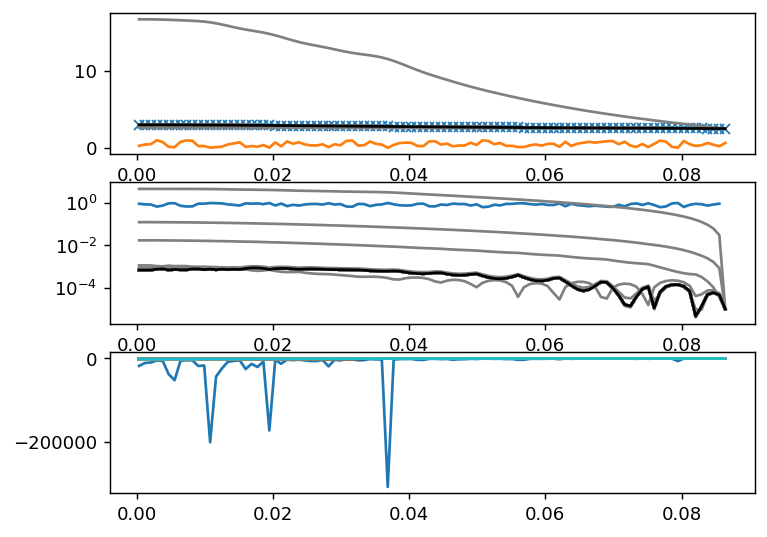

In [80]:
ψ_i = ψ_0

fig, ax = plt.subplots(3,1, dpi=130)

ax[0].plot(Rs, ψ, marker='x')
ax[0].plot(Rs, ψ_i)
ax[1].plot(Rs[:-1], (np.abs(ψ_i-ψ)/ψ)[:-1])

for i in range(100):

    S_ψ  = -2.0 * np.pi * E_tilde / ψ_i
    ax[2].plot(Rs, S_ψ)

    source_ψ = np.concatenate((S_ψ, [ψ[-1]]))

    # w_ψ_test = np.linalg.inv( Φ.T @  Φ + λ2_test * np.eye(N)) @  Φ.T @ ψ
    w_ψ      = np.linalg.inv(DΦ.T @ DΦ + λ2      * np.eye(N)) @ DΦ.T @ source_ψ
    
    ψ_i = Φ @ w_ψ

    ax[0].plot(Rs, ψ_i,              c='grey')
    ax[1].plot(Rs, np.abs(ψ_i-ψ)/ψ , c='grey')


ax[0].plot(Rs, ψ_i,             c='k')
ax[1].plot(Rs, np.abs(ψ_i-ψ)/ψ, c='k')
ax[1].set_yscale('log')

# plt.plot(w_ψ[::])
# plt.plot(-w_ψ[1::2])
# plt.plot(Rs,      Φ      @ w_ψ_test)

# plt.plot(Rs_fine, Φ_fine @ w_ψ)
# plt.plot(Rs, (DΦ @ w_ψ))


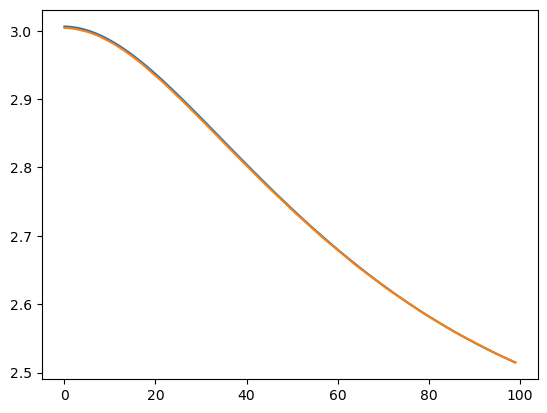

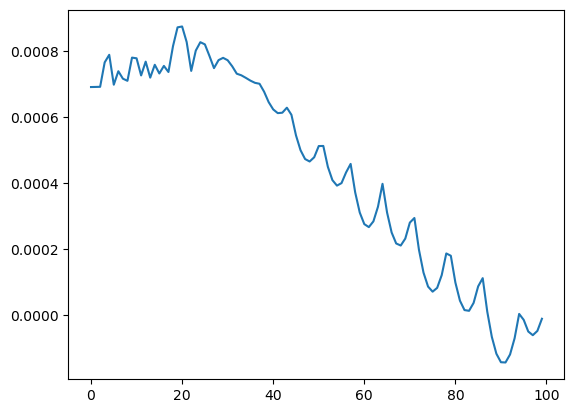

In [84]:
plt.plot(ψ_i)
plt.plot(ψ)

plt.figure()
plt.plot((ψ_i - ψ)/ψ)

In [81]:
w_ψ

array([ 2.51482908e+00,  0.00000000e+00,  1.00920323e-02,  0.00000000e+00,
        1.24524259e-03,  0.00000000e+00,  2.13970061e-04,  0.00000000e+00,
        4.93026852e-05,  0.00000000e+00,  1.22299517e-05,  0.00000000e+00,
        3.60039851e-06,  0.00000000e+00,  9.85281243e-07,  0.00000000e+00,
        3.24823451e-07,  0.00000000e+00,  1.06234489e-07,  0.00000000e+00,
        4.37187574e-08,  0.00000000e+00,  1.00221809e-08,  0.00000000e+00,
       -8.08470552e-09,  0.00000000e+00, -4.21581886e-09,  0.00000000e+00,
        1.70064307e-08,  0.00000000e+00, -1.09278594e-08,  0.00000000e+00,
        9.49726661e-10,  0.00000000e+00,  3.81681002e-09,  0.00000000e+00,
        5.47086682e-09,  0.00000000e+00, -5.20977124e-09,  0.00000000e+00,
        3.00743926e-10,  0.00000000e+00, -1.73923302e-09,  0.00000000e+00,
        3.43872092e-09,  0.00000000e+00, -5.25264394e-09,  0.00000000e+00,
        4.56641865e-09,  0.00000000e+00])

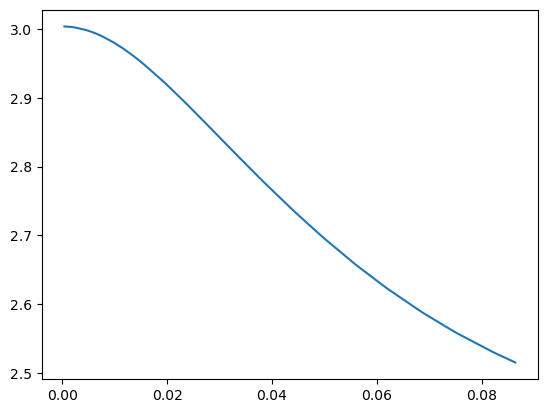

In [710]:
plt.plot(Rs, ψ)

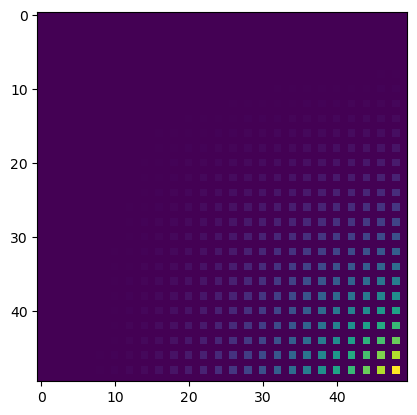

In [103]:
plt.imshow(DΦ.T @ DΦ)

In [104]:
np.linalg.inv(DΦ.T @ DΦ)

np.float64(0.0)

In [648]:
np.max(DΦ)

np.float64(190092050.69851184)

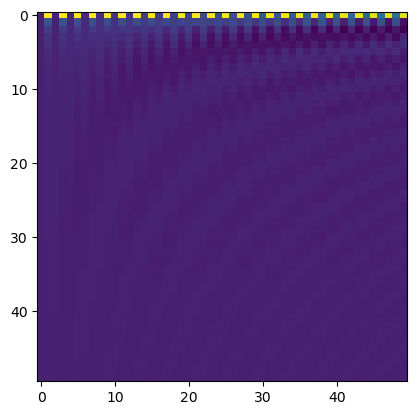

In [649]:
plt.imshow(Φ)

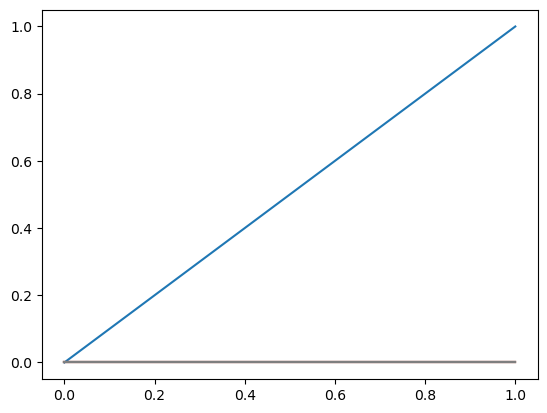

In [651]:
for i in range(8):
    # plt.plot(Rs,  Φ[:,2*i])
    plt.plot(DΦ[-2:,2*i])
# plt.yscale('log')

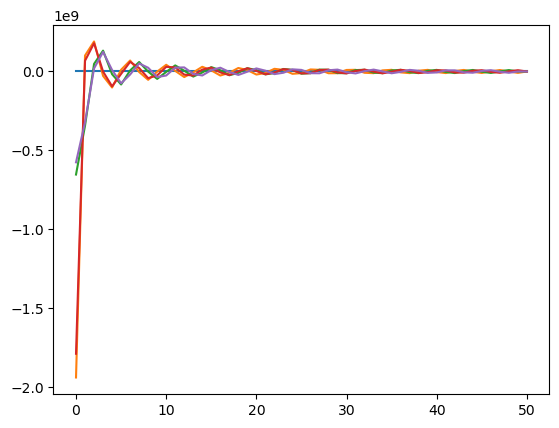

In [620]:
for i in range(5):
    # plt.plot(Rs,  Φ[:,2*i+1])
    plt.plot(DΦ[:,-i])
# plt.yscale('log')

In [621]:
for i in range(5):
    plt.plot(Rs, DΦ[:,=i])

SyntaxError: invalid syntax (450523487.py, line 2)

In [583]:
S_1

array([-6.28199735, -6.24457525, -6.14795374, -6.01911662, -5.84853827,
       -5.63879752, -5.4102753 , -5.16485208, -4.90917011, -4.65039573,
       -4.39207638, -4.13567022, -3.89285566, -3.6500411 , -3.42575676,
       -3.20787639, -2.99681913, -2.80769574, -2.61857235, -2.44447177,
       -2.28480351, -2.12513525, -1.97847689, -1.84719313, -1.71590937,
       -1.5846256 , -1.47537021, -1.36722149, -1.25907277, -1.16735469,
       -1.07784922, -0.98834374, -0.90387226, -0.82973355, -0.75559484,
       -0.68161563, -0.62023074, -0.55884586, -0.49746097, -0.43759479,
       -0.38667566, -0.33575652, -0.28483738, -0.23882327, -0.19667556,
       -0.15452785, -0.11238014, -0.07229933, -0.03614967,         nan])